<div style="background-color:#ddecfc; color:#100; padding:30px; border-radius:50px; max-width:1200px; margin:left;">

# Feature Engineering



- feature enrichment
- Preparing scales for modeling 

In [243]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import chi2_contingency, spearmanr 
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import pickle



%matplotlib inline

## <font color='Navy'> <h4>🔷 <u> Functions </u></h4>
- useful functions called along the code.

In [143]:
def mann_whitney_test(df, cont_features, target='is_fraud'):
    results = []
    for col in cont_features:
        fraud = df.loc[df[target] == 1, col]
        nonfraud = df.loc[df[target] == 0, col]
        stat, p = mannwhitneyu(fraud, nonfraud, alternative='two-sided')
        results.append((col, stat, p))
    return pd.DataFrame(results, columns=['Feature', 'U_stat', 'p_value']).sort_values('p_value')

In [144]:
def plot_categorical(df, feature, target="is_fraud"):
    # Group by profile and sum the frauds (1 means fraud)
    fraud_by_feature = df.groupby(feature)[target].sum()

    # Calculate the total number of transactions per profile
    total_transactions_by_feature = df.groupby(feature).size()

    # Calculate the percentage of fraud transactions for each profile
    fraud_percentage_by_feature = (fraud_by_feature / total_transactions_by_feature) * 100

    # Sort by the number of fraud cases in ascending order``
    fraud_by_feature = fraud_by_feature.sort_values(ascending=True)
    fraud_percentage_by_feature = fraud_percentage_by_feature[fraud_by_feature.index]
    
    # Set up the subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle(f'Fraud Analysis by {feature}', fontsize=16, fontweight='bold')

    # Plot 1: Fraud count by profile
    sns.barplot(x=fraud_by_feature.index, y=fraud_by_feature.values, palette='viridis', ax=axes[0])
    axes[0].set_xlabel(f'{feature}', fontsize=12)
    axes[0].set_ylabel(f'Number of Fraud Cases', fontsize=12)
    axes[0].set_title(f'Fraud Count by {feature}', fontsize=14)
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].grid(axis='y', linestyle='-', alpha=0.7)

    # Plot 2: Fraud percentage by profile
    sns.barplot(x=fraud_percentage_by_feature.index, y=fraud_percentage_by_feature.values , palette='coolwarm', ax=axes[1])
    axes[1].set_xlabel(f'{feature}', fontsize=12)
    axes[1].set_ylabel('Fraud Percentage (%)', fontsize=12)
    axes[1].set_title(f'Fraud Percentage by {feature}', fontsize=14)
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].grid(axis='y', linestyle='-', alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


In [145]:
def plot_fraud_rate_by_bin(df, feature):
    """
    Plots fraud rate by quantile bins of a specified feature.
    """

    df[f"{feature}_bin"] = pd.qcut(df[feature], q=10, duplicates="drop")

    fraud_rate_by_bin = (
        df.groupby(f"{feature}_bin")
        .agg(fraud_rate=("is_fraud", "mean"),
            count=("is_fraud", "size"))
        .reset_index()
    )

    fig, ax1 = plt.subplots(figsize=(10, 4))

    sns.lineplot(
        data=fraud_rate_by_bin,
        x=fraud_rate_by_bin.index,
        y="fraud_rate",
        marker="o",
        color="blue",
        ax=ax1
    )
    ax1.set_ylabel("Fraud Rate", color="blue")
    ax1.set_xlabel(f"{feature.title()} (Quantile Bin)")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Add volume as bars
    ax2 = ax1.twinx()
    sns.barplot(
        data=fraud_rate_by_bin,
        x=fraud_rate_by_bin.index,
        y="count",
        alpha=0.3,
        color="gray",
        ax=ax2
    )
    ax2.set_ylabel("Transaction Count", color="gray")

    plt.title(f"Fraud Rate by {feature.title()} (Quantile Bins)")
    plt.tight_layout()
    plt.show()

In [146]:
# enriching df with new features based on cc_num
# get credit card company from cc_num
def get_cc_company(cc_num):
    cc_num_str = str(cc_num)
    if re.match(r'^4[0-9]{12}(?:[0-9]{3})?$', cc_num_str):
        return 'Visa'
    elif re.match(r'^5[1-5][0-9]{14}$', cc_num_str):
        return 'MasterCard'
    elif re.match(r'^3[47][0-9]{13}$', cc_num_str):
        return 'American Express'
    elif re.match(r'^6(?:011|5[0-9]{2})[0-9]{12}$', cc_num_str):
        return 'Discover'
    elif re.match(r'^(352[89]|35[3-8][0-9])[0-9]{12}$', cc_num_str):
        return 'JCB'
    elif re.match(r'^(5018|5020|5038|6304|6759|6761|6763)[0-9]{8,15}$', cc_num_str):
        return 'Maestro'
    elif re.match(r'^(34|37)[0-9]{13}$', cc_num_str):
        return 'Diners Club'
    elif re.match(r'^(220[0-4]|2[2-7][0-9]{2})[0-9]{12}$', cc_num_str):
        return 'MIR'
    elif re.match(r'^(5019)[0-9]{12}$', cc_num_str):
        return 'Dankort'
    elif re.match(r'^(6304|6706|6771|6709)[0-9]{12,15}$', cc_num_str):
        return 'Laser'
    else:
        return 'Other'
    

## <font color='Navy'> <h4>🔷 <u> Data Load & Prep </u></h4>

In [179]:
df = pd.read_pickle("Data_Cleansed.pkl")

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518772 entries, 5428868 to 28708494
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   cc_num            518772 non-null  int64   
 1   city              518772 non-null  category
 2   state             518772 non-null  category
 3   city_pop          518772 non-null  int64   
 4   acct_num          518772 non-null  int64   
 5   trans_time        518772 non-null  int32   
 6   category          518772 non-null  category
 7   amt               518772 non-null  float64 
 8   is_fraud          518772 non-null  int64   
 9   merchant          518772 non-null  category
 10  trans_month       518772 non-null  category
 11  trans_day         518772 non-null  int32   
 12  trans_dayofweek   518772 non-null  category
 13  trans_hour        518772 non-null  category
 14  age               518772 non-null  int64   
 15  gender_encoded    518772 non-null  int8    
 16 

## <font color='Navy'> <h4>🔷 <u> Feature Engineering </u></h4>
Feature Engineering & Enrichment are done in order to:

- Improve model predictive power (better ROC, recall, precision)
- Reduce the model’s need to learn very complex patterns from scratch.

The following attempt will be done on the dataset before (train-test) split. <br>
Hence, <b> to avoid 'Data Leakage' </b> we will not be using anything related to the target 'feature' `is_fraud`
such as 'fature fraud rates' which we used to investigate the data in EDA.</br>
also, anything related to "future information" such as frequencies must be carfully avoided.

### <font color='Navy'> 1🔹<u><b>Feature Enrichment </u></b> </h3>

- Using data from existing features content and external related knowledge or labling related to them.

In [ ]:
# apply the function to create a new column 'cc_company' that indicates the credit card company :

df['cc_company'] = df['cc_num'].apply(get_cc_company)
df['cc_company'] = df['cc_company'].astype('category')

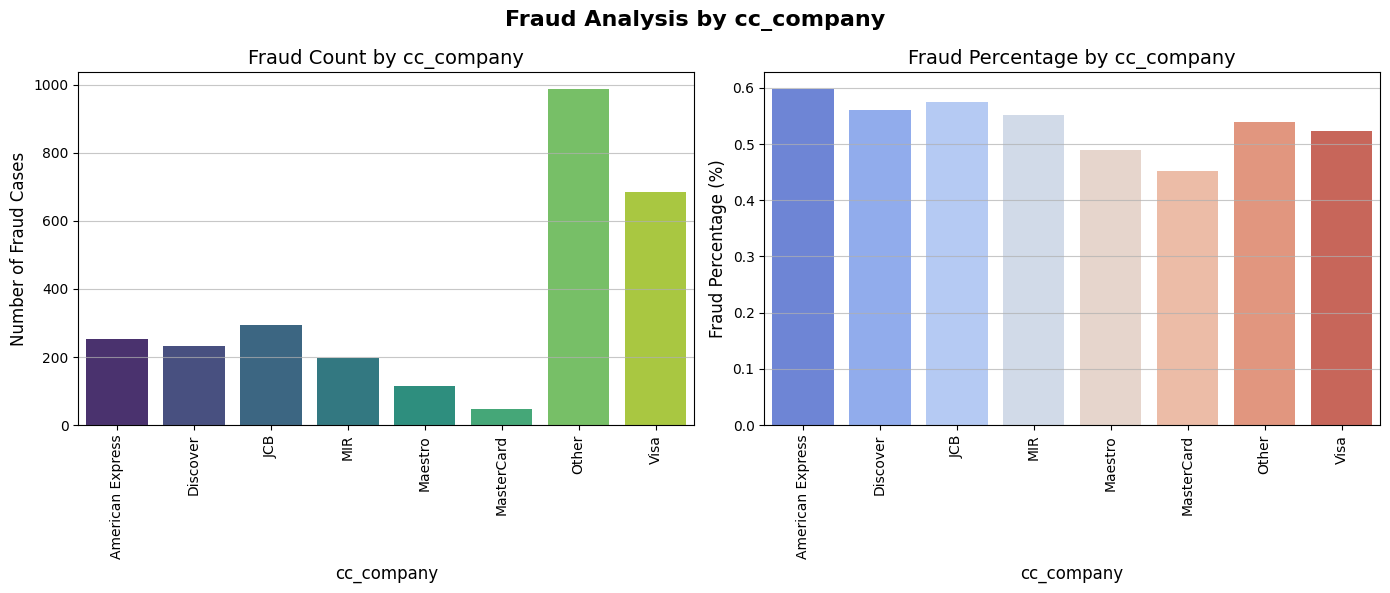

In [182]:
plot_categorical(df, 'cc_company')

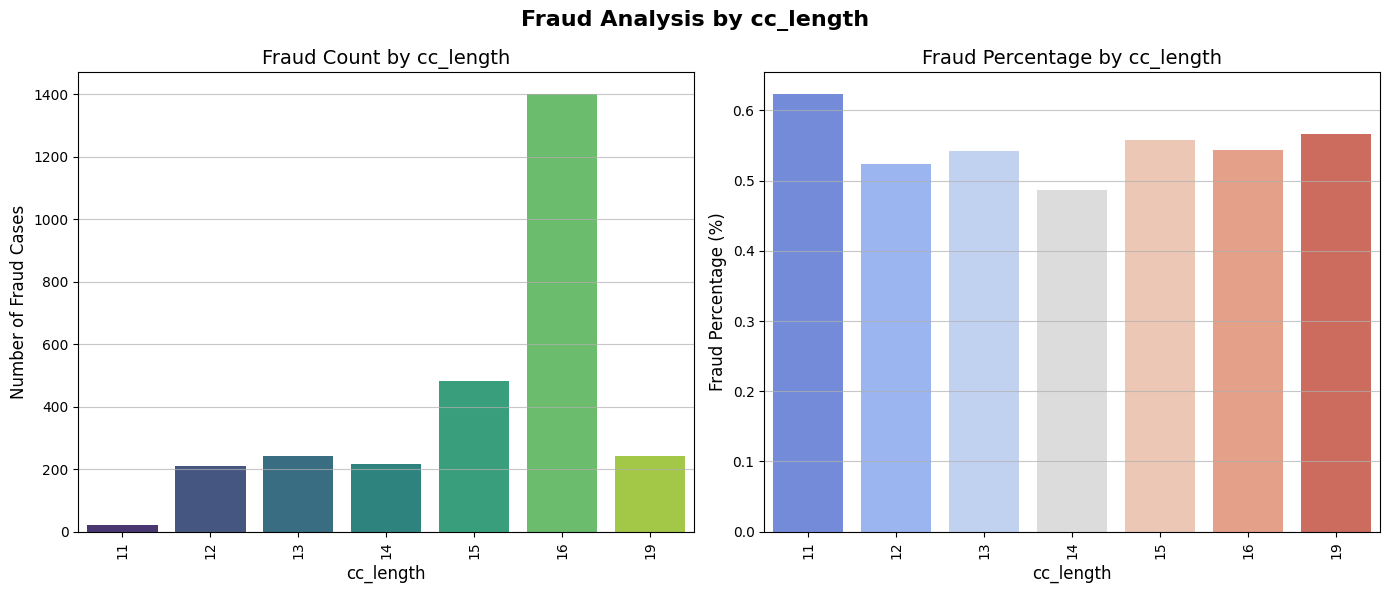

In [ ]:
# create a new feature 'cc_length' that indicates the length of the credit card number:

df['cc_length'] = df['cc_num'].astype(str).str.len()
df['cc_length'] = df['cc_length'].astype('category')
plot_categorical(df, 'cc_length')

#### <font color='Navy'> 1.2🔹<u><b>Evaluate Significance </u></b> </h3>

- Since this is a new categorical feature we will use Chi-Square Test (Categorical Feature Vs Categorical Target = `is_fraud`)


In [232]:
results = []

for cat in ['cc_length', 'cc_company']:
    contingency_table = pd.crosstab(df[cat], df['is_fraud'])
    chi2, p, dof, ex = chi2_contingency(contingency_table, correction=False)
    n = contingency_table.sum().sum()
    cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    results.append({
        'Variable': cat,
        'Chi2 Statistic': chi2,
        'p-value': p,
        'Degrees of Freedom': dof,
        'Cramers V': cramer_v
    })

chi2_results = pd.DataFrame(results).sort_values(by='p-value', ascending=True)
chi2_results


,Variable,Chi2 Statistic,p-value,Degrees of Freedom,Cramers V
1,cc_company,7.583325,0.370764,7,0.003823
0,cc_length,4.188025,0.651248,6,0.002841


<font color = 'Navy'> 

-  p-values are not great here (p> 0.05) ..  So for linear models these might not be useful.
</font>

### <font color='Navy'> 2🔹<u><b>EDA Based Feature Engineering  </u></b> </h3>
- Enriching the dataframe based on EDA results
- Evaluate the addition of some interaction features
- Verify if benificial for the model (mainly the linear ones) or if it could have learned those with the original features.

In [ ]:
# Enriching the dataframe based on EDA results

#from KW analysis- amt showed significant variation across all categorical groupings (category, hour, dayofweek, month).

df['amt_by_hour'] = df['amt'] * (df["trans_hour"].astype('int64') / 24)
df['amt_by_dayofweek'] = df['amt'] * (df['trans_dayofweek'].astype('int64') / 6)
df['amt_by_month'] = df['amt'] * (df['trans_month'].astype('int64') / 12)


In [ ]:
# Additional featues that might help the model based on EDA insights :
df['amt_log'] = np.log1p(df['amt'])
df['is_high_value'] = (df['amt'] > df['amt'].quantile(0.95)).astype(int)
df['amt_per_age'] = df['amt'] / (df['age'] + 1)
df['amt_to_city_pop'] = df['amt'] / (df['city_pop'] + 1)

#### <font color='Navy'> 2.2🔹<u><b>Evaluate Significance </u></b> </h3>

<font color = 'Navy'>
<u> 1) <b> Numerical Feature Vs Categorical Target = `is_fraud` : </b>

- Mann–Whitney U Test </u> : </font>
    - To verify if each feature matter at all for distinguishing fraud vs. non-fraud.

In [187]:
# Mann–Whitney U Test (Numerical Feature Vs Categorical Target = `is_fraud`)
mannwhitney_results = []
new_adds = ['amt_log', 'is_high_value', 'amt_per_age', 'amt_to_city_pop', 'amt_by_hour', 'amt_by_dayofweek', 'amt_by_month']
mannwhitney_results = mann_whitney_test(df, new_adds)
display(mannwhitney_results)

,Feature,U_stat,p_value
0,amt_log,1.222388e+09,0.000000e+00
1,is_high_value,1.246391e+09,0.000000e+00
2,amt_per_age,1.206619e+09,0.000000e+00
3,amt_to_city_pop,1.070883e+09,0.000000e+00
5,amt_by_dayofweek,1.091627e+09,0.000000e+00
6,amt_by_month,1.183088e+09,0.000000e+00
4,amt_by_hour,9.954570e+08,9.056256e-255


<font color ='Navy' >

- All enriched numeric features show extremely low p-values (<0.001),
- Meaning they significantly differ between fraud and non-fraud transactions - so we will keep those to feature selection evaluation.
- <b> But </b> there will be <b><u>colinearity </b></u>between them and the original features we used.
    - <b> We will let feature selection ranking check if there are clear diffrences, or if those relationships are caught by model.

 </font>

<font color = 'Navy'>
<u> 2) Spearman with `is_fraud` </u> : </font>

- to check how strongly and in what direction does it move with fraud.
- just quick estimation

In [239]:
new_adds = ['amt_log', 'is_high_value', 'amt_per_age', 'amt_to_city_pop', 'amt_by_hour', 'amt_by_dayofweek', 'amt_by_month']

results = []
for col in new_adds:
    corr, p = spearmanr(df[col], df['is_fraud'])
    results.append({'Feature': col, 'Spearman Corr': round(corr, 3), 'p-value': f"{p:.3e}"})

# Create a clean results table
results_df = pd.DataFrame(results).sort_values(by='p-value', ascending=True)
results_df


,Feature,Spearman Corr,p-value
0,amt_log,0.087,0.000e+00
1,is_high_value,0.242,0.000e+00
2,amt_per_age,0.084,0.000e+00
3,amt_to_city_pop,0.061,0.000e+00
5,amt_by_dayofweek,0.064,0.000e+00
6,amt_by_month,0.080,0.000e+00
4,amt_by_hour,0.047,4.723e-255


## <font color='Navy'> <h4>🔷 <u> Feature Encoding </u></h4>

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518772 entries, 5428868 to 28708494
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   cc_num            518772 non-null  int64   
 1   city              518772 non-null  category
 2   state             518772 non-null  category
 3   city_pop          518772 non-null  int64   
 4   acct_num          518772 non-null  int64   
 5   trans_time        518772 non-null  int32   
 6   category          518772 non-null  category
 7   amt               518772 non-null  float64 
 8   is_fraud          518772 non-null  int64   
 9   merchant          518772 non-null  category
 10  trans_month       518772 non-null  category
 11  trans_day         518772 non-null  int32   
 12  trans_dayofweek   518772 non-null  category
 13  trans_hour        518772 non-null  category
 14  age               518772 non-null  int64   
 15  gender_encoded    518772 non-null  int8    
 16 

In [190]:
#objects to category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')


In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518772 entries, 5428868 to 28708494
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   cc_num            518772 non-null  int64   
 1   city              518772 non-null  category
 2   state             518772 non-null  category
 3   city_pop          518772 non-null  int64   
 4   acct_num          518772 non-null  int64   
 5   trans_time        518772 non-null  int32   
 6   category          518772 non-null  category
 7   amt               518772 non-null  float64 
 8   is_fraud          518772 non-null  int64   
 9   merchant          518772 non-null  category
 10  trans_month       518772 non-null  category
 11  trans_day         518772 non-null  int32   
 12  trans_dayofweek   518772 non-null  category
 13  trans_hour        518772 non-null  category
 14  age               518772 non-null  int64   
 15  gender_encoded    518772 non-null  int8    
 16 

### <font color='Navy'> 1🔹Pre Encoding EDA Based Data Drops </u></b> </h3>

#### <font color='Navy'> 1.1🔹Insignificant EDA Ranked Categories : </u></b> </h3>

In [202]:
# insignificant columns to drop based on EDA and statistical test :
cat_insignificant = ['city_pop_bin', 'zip_region', 'state', 'job_category', 'location_profile']
df = df.drop(columns=cat_insignificant)


#### <font color='Navy'> 1.2🔹Categorical Features Ranked With High Cardinality: </u></b> </h3>

In [203]:
# Select categorical columns (objects or pandas 'category' dtype)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

# Count unique values per categorical column
cat_cardinality = df[cat_cols].nunique().sort_values(ascending=False)
print("\nUnique values per categorical column:")
print(cat_cardinality)

# Optional: flag high-cardinality columns (e.g., >100 unique values)
high_card_thresh = 100
high_card_cols = cat_cardinality[cat_cardinality > high_card_thresh]
print("High-cardinality categorical columns (possible drop/re-group):")
print(high_card_cols)


Categorical columns: ['city', 'category', 'merchant', 'trans_month', 'trans_dayofweek', 'trans_hour', 'age_group', 'category_clean', 'amt_bin', 'cc_company', 'cc_length']

Unique values per categorical column:
city               4937
merchant            662
trans_hour           24
category             14
category_clean       14
trans_month          12
amt_bin              10
cc_company            8
trans_dayofweek       7
cc_length             7
age_group             3
dtype: int64
High-cardinality categorical columns (possible drop/re-group):
city        4937
merchant     662
dtype: int64


#### <font color='Navy'> 1.3🔹Drop Unnecessary/Noise Columns Before Encoding :</u></b> </h3>

In [204]:
# Columns to drop:
# - acct_num, cc_num: identifiers (non-informative, potential leakage)
# - merchant, city: high-cardinality categoricals (~600+ uniques)
# - amt_bin, city_pop_bin: redundant binned versions of continuous features
# - age_group: optional (binned version of 'age')
#  'cc_company', 'cc_length'  dropped due to non-significance

drop_cols = ['acct_num', 'cc_num', 'merchant', 'city','amt_bin', 'city_pop_bin', 'age_group','cc_company', 'cc_length' ]
drop_cols = [c for c in drop_cols if c in df.columns]
print("Dropping columns:", drop_cols)
df_clean = df.drop(columns=drop_cols)
print(f"\nShape: {df.shape} → {df_clean.shape}")




Dropping columns: ['acct_num', 'cc_num', 'merchant', 'city', 'amt_bin', 'age_group', 'cc_company', 'cc_length']

Shape: (518772, 29) → (518772, 21)


In [205]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518772 entries, 5428868 to 28708494
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   city_pop          518772 non-null  int64   
 1   trans_time        518772 non-null  int32   
 2   category          518772 non-null  category
 3   amt               518772 non-null  float64 
 4   is_fraud          518772 non-null  int64   
 5   trans_month       518772 non-null  category
 6   trans_day         518772 non-null  int32   
 7   trans_dayofweek   518772 non-null  category
 8   trans_hour        518772 non-null  category
 9   age               518772 non-null  int64   
 10  gender_encoded    518772 non-null  int8    
 11  distance_km       518772 non-null  float64 
 12  category_clean    518772 non-null  category
 13  is_online         518772 non-null  int64   
 14  amt_by_hour       518772 non-null  float64 
 15  amt_by_dayofweek  518772 non-null  float64 
 16 

In [ ]:
# Get Categorical columns after cleaning :
cat_cols = df_clean.select_dtypes(include=['category']).columns.tolist()
print("Categorical columns:", cat_cols)


Categorical columns: ['category', 'trans_month', 'trans_dayofweek', 'trans_hour', 'category_clean']


In [207]:
print("Unique values in category:", df['category'].nunique())
print("Unique values in category_clean:", df['category_clean'].nunique())

# Optional: see if they're aligned
pd.crosstab(df['category'], df['category_clean'])


Unique values in category: 14
Unique values in category_clean: 14


category_clean,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
category,,,,,,,,,,,,,,
entertainment,65089,0,0,0,0,0,0,0,0,0,0,0,0,0
food_dining,0,77593,0,0,0,0,0,0,0,0,0,0,0,0
gas_transport,0,0,232,0,0,0,0,0,0,0,0,0,0,0
grocery_net,0,0,0,46,0,0,0,0,0,0,0,0,0,0
grocery_pos,0,0,0,0,601,0,0,0,0,0,0,0,0,0
health_fitness,0,0,0,0,0,65169,0,0,0,0,0,0,0,0
home,0,0,0,0,0,0,97106,0,0,0,0,0,0,0
kids_pets,0,0,0,0,0,0,0,90600,0,0,0,0,0,0
misc_net,0,0,0,0,0,0,0,0,399,0,0,0,0,0


In [208]:
# drop original 'category' column
df_clean = df_clean.drop(columns=['category'])

### <font color='Navy'> 2🔹Feature Encoding </u></b> </h3>

#### <font color='Navy'> 2.1🔹Categorical Features to be encoded: </u></b> </h3>

In [209]:
cat_cols = df_clean.select_dtypes(include=['category']).columns.tolist()
print("Categorical columns:", cat_cols)

Categorical columns: ['trans_month', 'trans_dayofweek', 'trans_hour', 'category_clean']


#### <font color='Navy'> 2.2🔹Apply Encoding </u></b> </h3>

- ['trans_month', 'trans_dayofweek', 'trans_hour'] have cyclic pattern.
    - To allow models to know that 1 (Jan) is comes after 12 (Dec) and is close to it as well, we can use `cyclic encoding`.
- for `category_clean` we will apply "get dummies". 

In [211]:
# Ensure time features are numeric (not categorical)
time_cols = ['trans_month', 'trans_dayofweek', 'trans_hour']
for col in time_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Helper function for cyclical features
def add_cyclical_features(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    df = df.drop(columns=[col])
    return df

# Apply cyclical encoding
df_encoded = df_clean.copy()
df_encoded = add_cyclical_features(df_encoded, 'trans_month', 12)
df_encoded = add_cyclical_features(df_encoded, 'trans_dayofweek', 7)
df_encoded = add_cyclical_features(df_encoded, 'trans_hour', 24)

# One-hot encode category_clean
df_encoded = pd.get_dummies(df_encoded, columns=['category_clean'], drop_first=True)

print(f"Shape after encoding: {df_clean.shape} → {df_encoded.shape}")


Shape after encoding: (518772, 20) → (518772, 35)


## <font color='Navy'> <h4>🔷 <u> Feature Scaling </u></h4>

### <font color='Navy'> 1🔹Train/Test Split (Before Scaling) </u></b> </h3>
- To aviod data leakage, i've decided to split the dataset before scaling or feature selection.

In [213]:
y = df_encoded['is_fraud']  # target variable
X = df_encoded.drop(columns=['is_fraud']) # features except target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Fraud ratio in Train: {y_train.mean():.4f}, Test: {y_test.mean():.4f}")


Train shape: (363140, 34), Test shape: (155632, 34)
Fraud ratio in Train: 0.0054, Test: 0.0054


### <font color='Navy'> 2🔹Apply Scaling </u></b> </h3>


In [215]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data only, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Scaling complete!")
print(f"X_train mean (first 5 cols):\n{X_train_scaled.mean().head()}")
print(f"X_train std (first 5 cols):\n{X_train_scaled.std().head()}")


Scaling complete!
X_train mean (first 5 cols):
city_pop     -3.052395e-17
trans_time    9.118051e-18
amt          -1.565331e-17
trans_day    -7.544894e-17
age           7.435321e-17
dtype: float64
X_train std (first 5 cols):
city_pop      1.000001
trans_time    1.000001
amt           1.000001
trans_day     1.000001
age           1.000001
dtype: float64


## <font color='Navy'> <h4>🔷 <u> Combined Feature Selection Table </u></h4>

In [217]:
# Initialize and fit models
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000).fit(X_train_scaled, y_train)
ridge = Ridge(alpha=0.01, random_state=42).fit(X_train_scaled, y_train)
svm = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000, random_state=42).fit(X_train_scaled, y_train)
gb = GradientBoostingClassifier(random_state=42).fit(X_train_scaled, y_train)
rf = RandomForestClassifier(random_state=42, n_estimators=200).fit(X_train_scaled, y_train)

# Create selection table
selection_df = pd.DataFrame({
    'Feature': X_train.columns,
    'LASSO': (np.abs(lasso.coef_) > 0).astype(int),
    'Ridge': (np.abs(ridge.coef_) > 0).astype(int),
    'SVM': (np.abs(svm.coef_[0]) > 0).astype(int),
    'GB': (gb.feature_importances_ > 0).astype(int),
    'RF': (rf.feature_importances_ > 0).astype(int)
})

# Add importance scores
selection_df['LASSO_coef'] = lasso.coef_
selection_df['Ridge_coef'] = ridge.coef_
selection_df['GB_importance'] = gb.feature_importances_
selection_df['RF_importance'] = rf.feature_importances_

# Sum selections (how many models picked the feature)
selection_df['Selected_by'] = selection_df[['LASSO', 'Ridge', 'SVM', 'GB', 'RF']].sum(axis=1)

# Sort by consensus
selection_df = selection_df.sort_values('Selected_by', ascending=False).reset_index(drop=True)

# Display summary
print(selection_df.head(15))


                         Feature  LASSO  Ridge  SVM  GB  RF  LASSO_coef  \
0        category_clean_misc_pos      1      1    1   1   1    0.002496   
1                      is_online      1      1    1   1   1    0.036105   
2   category_clean_gas_transport      1      1    1   1   1    0.011000   
3     category_clean_grocery_pos      1      1    1   1   1    0.023990   
4          category_clean_travel      0      1    1   1   1   -0.000000   
5                     trans_time      0      1    1   1   1   -0.000000   
6                    amt_by_hour      0      1    1   1   1    0.000000   
7                            amt      0      1    1   1   1    0.000000   
8                 gender_encoded      0      1    1   1   1   -0.000000   
9                            age      0      1    1   1   1    0.000000   
10               trans_month_cos      0      1    1   1   1    0.000000   
11                   amt_per_age      0      1    1   1   1    0.000000   
12               trans_mo

In [221]:
selection_df.head(20)

,Feature,LASSO,Ridge,SVM,GB,RF,LASSO_coef,Ridge_coef,GB_importance,RF_importance,Selected_by
0,category_clean_misc_pos,1,1,1,1,1,0.002496,0.012177,0.027531,0.014056,5
1,is_online,1,1,1,1,1,0.036105,0.022317,0.376951,0.163709,5
2,category_clean_gas_transport,1,1,1,1,1,0.011000,0.020542,0.077719,0.052175,5
3,category_clean_grocery_pos,1,1,1,1,1,0.023990,0.032994,0.203383,0.131605,5
4,category_clean_travel,0,1,1,1,1,-0.000000,0.000610,0.002102,0.001757,4
5,trans_time,0,1,1,1,1,-0.000000,-0.001439,0.006226,0.039939,4
6,amt_by_hour,0,1,1,1,1,0.000000,0.003476,0.024062,0.052207,4
7,amt,0,1,1,1,1,0.000000,0.005005,0.016443,0.054711,4
8,gender_encoded,0,1,1,1,1,-0.000000,-0.000385,0.000469,0.003556,4
9,age,0,1,1,1,1,0.000000,-0.000044,0.007126,0.045895,4


In [218]:
# Keep features selected by at least 4 models
selected_features = selection_df.loc[selection_df["Selected_by"] >= 4, "Feature"]

# Subset your training and test data
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"Selected {len(selected_features)} features:")
print(selected_features.tolist())


Selected 22 features:
['category_clean_misc_pos', 'is_online', 'category_clean_gas_transport', 'category_clean_grocery_pos', 'category_clean_travel', 'trans_time', 'amt_by_hour', 'amt', 'gender_encoded', 'age', 'trans_month_cos', 'amt_per_age', 'trans_month_sin', 'category_clean_food_dining', 'trans_hour_sin', 'distance_km', 'amt_by_dayofweek', 'amt_log', 'category_clean_shopping_pos', 'category_clean_personal_care', 'category_clean_home', 'trans_hour_cos']


In [220]:
rf_full = RandomForestClassifier(random_state=42).fit(X_train_scaled, y_train)
rf_sel = RandomForestClassifier(random_state=42).fit(X_train_selected, y_train)

print("Full feature AUC:", roc_auc_score(y_test, rf_full.predict_proba(X_test_scaled)[:,1]))
print("Selected feature AUC:", roc_auc_score(y_test, rf_sel.predict_proba(X_test_selected)[:,1]))


Full feature AUC: 0.9960462357504231
Selected feature AUC: 0.9924995793053503


- feature selection shows that only 4/5 models selected the `amt` and `amt_log`.
- amt and amt_log are almost perfectly correlated, so keeping both adds collinearity noise.
- Recall that linear models are not handling a highly skewed data well so the fact that log form as not only selected by the linear onces but ranked lower, can give us the confidance of removeing it.

Regarding the rest of the add-ins deduced fromm `amt`:
- While statistical tests confirmed that these engineered features have predictive signal,
the model selection results indicate that the model can already infer these relationships internally.
Thus, features such as is_high_value or amt_by_* can be safely excluded without loss of predictive performance,
as they do not add new information beyond existing amount-related variables.


### <font color='Navy'> 3🔹<u><b>Remove Redundant Engineered Features </u></b> </h3>

In [233]:
X_train_reduced = X_train_scaled.drop(columns=['amt_log', 'amt_by_hour', 'amt_by_dayofweek', 'amt_by_month'], errors='ignore')
X_test_reduced  = X_test_scaled.drop(columns=['amt_log', 'amt_by_hour', 'amt_by_dayofweek', 'amt_by_month'], errors='ignore')

In [ ]:
lasso = Lasso(alpha=0.01, max_iter=10000).fit(X_train_reduced, y_train)
ridge = Ridge(alpha=0.01, max_iter=10000).fit(X_train_reduced, y_train)
svm   = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000).fit(X_train_reduced, y_train)
gb    = GradientBoostingClassifier().fit(X_train_reduced, y_train)
rf    = RandomForestClassifier().fit(X_train_reduced, y_train)

selection_df = pd.DataFrame({
    "Feature": X_train_reduced.columns,
    "LASSO": (np.abs(lasso.coef_) > 0).astype(int),
    "Ridge": (np.abs(ridge.coef_) > 0).astype(int),
    "SVM": (np.abs(svm.coef_[0]) > 0).astype(int),
    "GB": (gb.feature_importances_ > 0).astype(int),
    "RF": (rf.feature_importances_ > 0).astype(int),
})

# Add importance scores
selection_df['LASSO_coef'] = lasso.coef_
selection_df['Ridge_coef'] = ridge.coef_
selection_df['GB_importance'] = gb.feature_importances_
selection_df['RF_importance'] = rf.feature_importances_

# Sum selections (how many models picked the feature)
selection_df['Selected_by'] = selection_df[['LASSO', 'Ridge', 'SVM', 'GB', 'RF']].sum(axis=1)

# Sort by consensus
selection_df = selection_df.sort_values('Selected_by', ascending=False).reset_index(drop=True)

# Display summary
print(selection_df.head(15))

                         Feature  LASSO  Ridge  SVM  GB  RF  LASSO_coef  \
0                      is_online      1      1    1   1   1    0.036105   
1     category_clean_grocery_pos      1      1    1   1   1    0.023990   
2   category_clean_gas_transport      1      1    1   1   1    0.011000   
3        category_clean_misc_pos      1      1    1   1   1    0.002496   
4                            amt      0      1    1   1   1    0.000000   
5                       city_pop      0      1    1   1   1    0.000000   
6            trans_dayofweek_sin      0      1    1   1   1    0.000000   
7                    amt_per_age      0      1    1   1   1    0.000000   
8                trans_month_cos      0      1    1   1   1    0.000000   
9                trans_month_sin      0      1    1   1   1    0.000000   
10                trans_hour_sin      0      1    1   1   1    0.000000   
11                           age      0      1    1   1   1    0.000000   
12                gender_

✅ The top-tier features are exactly what we’d expect for predicting fraud or spending behavior:

is_online — online transactions are naturally higher fraud risk.

Category-based signals (category_clean_*) — highly predictive of fraud context (POS vs Net, Gas, etc.).

amt, amt_per_age, amt_by_* — transaction size and relative context.

Temporal encodings (trans_hour_*, trans_month_*) — transaction timing patterns matter.

So the models are aligned with real-world intuition. That’s a very good sign.

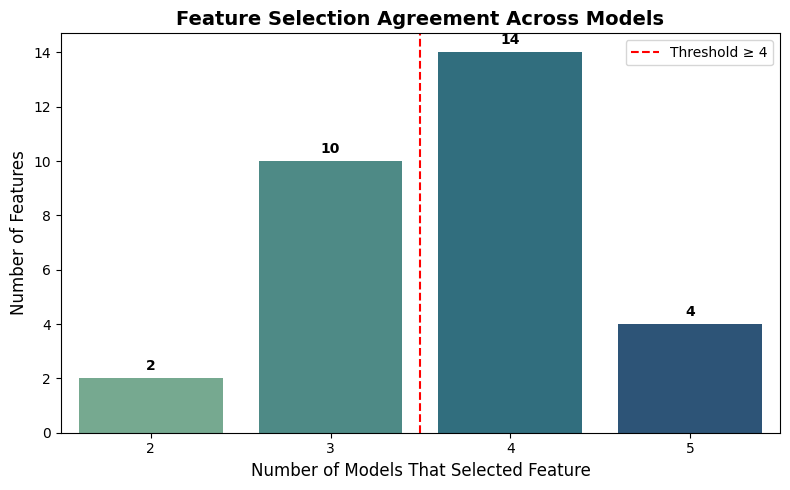

In [235]:
# Count how many features were selected by how many models
selection_counts = selection_df["Selected_by"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    x=selection_counts.index,
    y=selection_counts.values,
    palette="crest"
)

# Add count labels above bars
for i, v in enumerate(selection_counts.values):
    plt.text(i, v + 0.3, str(v), ha='center', fontweight='bold')

# Formatting and labels
plt.axvline(x=selection_counts.index.get_loc(4) - 0.5, color='red', linestyle='--', label='Threshold ≥ 4')
plt.title("Feature Selection Agreement Across Models", fontsize=14, fontweight="bold")
plt.xlabel("Number of Models That Selected Feature", fontsize=12)
plt.ylabel("Number of Features", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


In [236]:
selected_features = selection_df.loc[selection_df["Selected_by"] >= 4, "Feature"]

# Subset your training and test data
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"Selected {len(selected_features)} features:")
print(selected_features.tolist())


Selected 18 features:
['city_pop', 'trans_time', 'amt', 'age', 'gender_encoded', 'is_online', 'amt_per_age', 'trans_month_sin', 'trans_month_cos', 'trans_dayofweek_sin', 'trans_hour_sin', 'trans_hour_cos', 'category_clean_gas_transport', 'category_clean_grocery_pos', 'category_clean_home', 'category_clean_misc_pos', 'category_clean_shopping_pos', 'category_clean_travel']


In [244]:
# Define the file names
save_path = "data_splits_selected.pkl"

# Bundle all relevant data together in one file
data_to_save = {
    "X_train_sel":  X_train_selected,
    "X_test_sel": X_test_selected ,
    "y_train": y_train,
    "y_test": y_test,
    "selected_features": X_train_selected.columns.tolist()
}

# Save to pickle
with open(save_path, "wb") as f:
    pickle.dump(data_to_save, f)

print(f"✅ Saved successfully to {save_path}")


✅ Saved successfully to data_splits_selected.pkl


In [237]:
rf_full = RandomForestClassifier(random_state=42).fit(X_train_scaled, y_train)
rf_sel = RandomForestClassifier(random_state=42).fit(X_train_selected, y_train)

print("Full feature AUC:", roc_auc_score(y_test, rf_full.predict_proba(X_test_scaled)[:,1]))
print("Selected feature AUC:", roc_auc_score(y_test, rf_sel.predict_proba(X_test_selected)[:,1]))


Full feature AUC: 0.9960462357504231
Selected feature AUC: 0.9881635195093929


In [ ]:
df